In [4]:
import gzip
import pickle
import networkx as nx
import pandas as pd
import numpy as np
import random
import os
from pebble import lattice

In [5]:
from torch.optim import SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau 

## Data Loading

### Writing PyG Dataset

In [6]:
import torch

In [7]:
from torch_geometric.data import InMemoryDataset
from torch.utils.data import DataLoader

In [8]:
from torch_geometric.utils import from_networkx, to_networkx

In [9]:
def clustering_coefficient(G, node):
    ns = [n for n in G.neighbors(node)]
    if len(ns) <= 1:
        return 0
    
    numerator = 0
    denominator = len(ns) * (len(ns) - 1) / 2
    for i in range(0, len(ns)):
        for j in range(i+1, len(ns)):
            n1, n2 = ns[i], ns[j]
            numerator += G.has_edge(n1, n2)
    
    return numerator / denominator
                

In [10]:
def generate_feature_vector(G):
    x = torch.randn(G.number_of_nodes(), 4)
    ind = 0
    for node in G.nodes():
        x[ind][0] = 1 # uniform
        x[ind][1] = G.degree[node] # node degree as a scalar 
        x[ind][2] = clustering_coefficient(G, node) # triangle counting?
        x[ind][3] = ind # node ID features
        ind += 1
    return x

In [11]:
class LamanDataset(InMemoryDataset):
    def __init__(self, root, data_dir, transform=None, pre_transform=None, pre_filter=None):
        self.data_dir = data_dir
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def processed_file_names(self):
        return ['data.pt']
        
    def process(self):
        total_laman_data = None
        with gzip.open(self.data_dir, 'r') as f:
            total_laman_data = pickle.load(f)
            
        data_list = []
        for ind, graph in enumerate(total_laman_data[0]):
            x = generate_feature_vector(graph)
            graph_as_data = from_networkx(graph)
            graph_as_data.x = x
            graph_as_data.label = 0
            data_list.append(graph_as_data)
            
        for ind, graph in enumerate(total_laman_data[1]):
            x = generate_feature_vector(graph)
            graph_as_data = from_networkx(graph)
            graph_as_data.x = x
            graph_as_data.label = 1
            data_list.append(graph_as_data)
            
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [12]:
DATA_PATH = "data/custom-generated.pkl.gz"

In [13]:
laman_data = LamanDataset("", DATA_PATH)

In [14]:
laman_data[0]

Data(edge_index=[2, 74], x=[20, 4], label=[1], num_nodes=20)

## Split into Train / Test

In [15]:
from torch.utils.data import random_split

proportions = [.7, .3]
lengths = [int(p * len(laman_data)) for p in proportions]
lengths[-1] = len(laman_data) - sum(lengths[:-1])

generator1 = torch.Generator().manual_seed(42)
train_data, test_data = random_split(laman_data, lengths, generator=generator1)

In [16]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_data, batch_size = 64, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 64, shuffle=True)

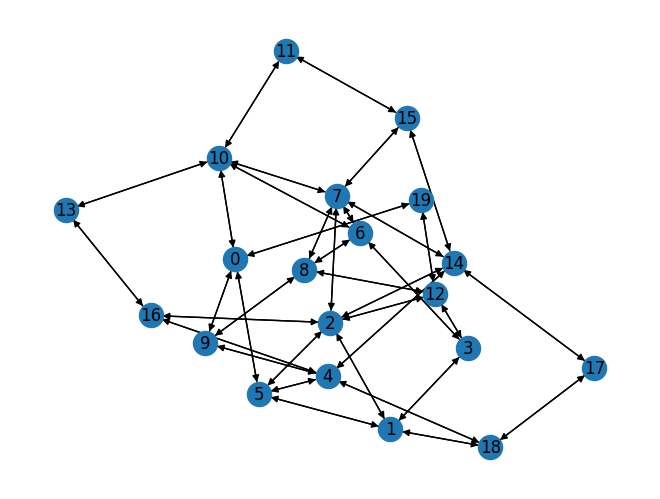

In [17]:
nx.draw(to_networkx(train_data[1]), with_labels = True)

In [18]:
from pebble import lattice

In [19]:
print(g.number_of_edges())

NameError: name 'g' is not defined

In [ ]:
num_independent_edges = 0

l = lattice()
g = to_networkx(train_data[1])
g.add_edge(0, 8)

for u, v in g.edges():
    if l.add_bond(u, v):
        num_independent_edges += 1
    elif u < v:
        print("redundant")
        print(u, v)

In [20]:
l.stat()
print(l.statistics)

NameError: name 'l' is not defined

In [21]:
num_independent_edges

NameError: name 'num_independent_edges' is not defined

In [22]:
train_data[1].label

tensor([0])

In [23]:
print("Number of train batches: ", len(train_loader))
print("Number of test batches: ", len(test_loader))

Number of train batches:  386
Number of test batches:  166


In [24]:
for data in train_loader:
    print(data)
    break

DataBatch(edge_index=[2, 4736], x=[1280, 4], label=[64], num_nodes=1280, batch=[1280], ptr=[65])


## Model Architecture & Training

In [25]:
from basic_gcn.gcn_k_layers import GCN

In [26]:
model = GCN(num_features=4, dim_h=4, layers=10)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (conv_layers): ModuleList(
    (0): GCNConv(4, 4)
    (1): GCNConv(4, 4)
    (2): GCNConv(4, 4)
    (3): GCNConv(4, 4)
    (4): GCNConv(4, 4)
    (5): GCNConv(4, 4)
    (6): GCNConv(4, 4)
    (7): GCNConv(4, 4)
    (8): GCNConv(4, 4)
    (9): GCNConv(4, 4)
  )
  (lin1): Linear(in_features=120, out_features=120, bias=True)
  (lin2): Linear(in_features=120, out_features=1, bias=True)
)
Number of parameters:  14841


In [27]:
from torch_geometric.data import DataLoader
from torch.nn import BCELoss
import warnings
warnings.filterwarnings("ignore")

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),
                                      lr=0.001)

# scheduler = ReduceLROnPlateau(optimizer, 'min', min_lr=1e-6, verbose=True, patience=10)

In [28]:
def train(data, features_to_use):
    ind = 0
    model.train()
    for batch in data:
        optimizer.zero_grad()
        pred, embedding = model(batch.x[:, features_to_use], batch.edge_index, batch.batch)
        pred = torch.squeeze(pred)
        loss = loss_fn(pred.float(), batch.label.float())
        loss.backward()
        optimizer.step()
        ind += 1

    return loss, None

In [29]:
def check_accuracy(model, loader, features_to_use):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for batch in loader:
            pred, embedding = model(batch.x[:, features_to_use], batch.edge_index, batch.batch)
            pred = torch.squeeze(pred)
            y = batch.label
            predictions = (pred > 0.5).long() 
            num_correct += (predictions == y).sum() 
            num_samples += predictions.size(0)
            
    return float(num_correct)/float(num_samples)*100

In [30]:
print("Starting training...")
losses = []

bestModel, highestAcc = None, 0

for epoch in range(300):
    loss, _ = train(train_loader, [0, 1, 2, 3])
    losses.append(loss)
    print(f"Epoch {epoch} | Train loss {loss}")
    train_acc, test_acc = check_accuracy(model, train_loader, [0, 1, 2, 3]), check_accuracy(model, test_loader, [0, 1, 2, 3])
    print(f"Train Accuracy {train_acc} | Test Accuracy {test_acc}")
    
    if test_acc > highestAcc:
        highestAcc = test_acc
        bestModel = model

Starting training...
Epoch 0 | Train loss 0.5774704813957214
Train Accuracy 71.42509530375537 | Test Accuracy 72.1233913701741
Epoch 1 | Train loss 0.5747166872024536
Train Accuracy 72.56468488928543 | Test Accuracy 73.01286903860712
Epoch 2 | Train loss 0.4559752643108368
Train Accuracy 70.01784410738908 | Test Accuracy 70.59046177138532
Epoch 3 | Train loss 0.5806797742843628
Train Accuracy 74.13009976478222 | Test Accuracy 74.36601059803179
Epoch 4 | Train loss 0.33474743366241455
Train Accuracy 74.0854894963095 | Test Accuracy 74.29031037093111
Epoch 5 | Train loss 0.8780611753463745
Train Accuracy 76.53499878335631 | Test Accuracy 76.25851627554883
Epoch 6 | Train loss 0.5226027965545654
Train Accuracy 76.26733717252007 | Test Accuracy 75.99356548069645
Epoch 7 | Train loss 0.3762814700603485
Train Accuracy 77.16359802092627 | Test Accuracy 77.17638152914459
Epoch 8 | Train loss 0.36851900815963745
Train Accuracy 78.34374239597696 | Test Accuracy 78.04693414080242
Epoch 9 | Train 

Epoch 76 | Train loss 0.21931962668895721
Train Accuracy 90.61156622597129 | Test Accuracy 90.26305828917486
Epoch 77 | Train loss 0.08738645166158676
Train Accuracy 89.73152729337335 | Test Accuracy 89.30734292202877
Epoch 78 | Train loss 0.09483485668897629
Train Accuracy 90.34796009408711 | Test Accuracy 89.70476911430735
Epoch 79 | Train loss 0.21111972630023956
Train Accuracy 89.41925541406441 | Test Accuracy 88.97615442846329
Epoch 80 | Train loss 0.1984294205904007
Train Accuracy 91.64571335874767 | Test Accuracy 90.88758516275549
Epoch 81 | Train loss 0.4861302971839905
Train Accuracy 91.65787979560386 | Test Accuracy 90.7551097653293
Epoch 82 | Train loss 0.33904972672462463
Train Accuracy 92.09587152242679 | Test Accuracy 91.35124905374717
Epoch 83 | Train loss 0.4128945767879486
Train Accuracy 91.77954416416578 | Test Accuracy 91.18092354277063
Epoch 84 | Train loss 0.08225583285093307
Train Accuracy 92.01476194338551 | Test Accuracy 91.34178652535958
Epoch 85 | Train loss 0

KeyboardInterrupt: 

In [ ]:
# sanity check

In [ ]:
# test on best model

In [ ]:
# square
import networkx as nx
square = nx.Graph()
square.add_edge(0, 1)
square.add_edge(1, 3)
square.add_edge(0, 2)
square.add_edge(2, 3)

In [ ]:
# square with cross bar (rigid)
import networkx as nx
square_bar = nx.Graph()
square_bar.add_edge(0, 1)
square_bar.add_edge(1, 3)
square_bar.add_edge(0, 2)
square_bar.add_edge(2, 3)
square_bar.add_edge(0, 3)

In [ ]:
# triangle
import networkx as nx
triangle = nx.Graph()
triangle.add_edge(0, 1)
triangle.add_edge(0, 2)
triangle.add_edge(1, 2)

In [ ]:
# pentagon
import networkx as nx
pentagon = nx.Graph()
pentagon.add_edge(0, 1)
pentagon.add_edge(1, 3)
pentagon.add_edge(3, 4)
pentagon.add_edge(4, 2)
pentagon.add_edge(2, 0)

In [ ]:
# no triangle and rigid
rigid = nx.Graph()
rigid.add_edge(0, 1)
rigid.add_edge(0, 2)
rigid.add_edge(0, 4)
rigid.add_edge(1, 2)
rigid.add_edge(1, 5)
rigid.add_edge(2, 3)
rigid.add_edge(3, 4)
rigid.add_edge(3, 5)
rigid.add_edge(4, 5)

In [ ]:
# no triangle and rigid
rigid = nx.Graph()
rigid.add_edge(0, 1)
rigid.add_edge(0, 2)
rigid.add_edge(0, 4)
rigid.add_edge(1, 2)
rigid.add_edge(1, 5)
rigid.add_edge(2, 3)
rigid.add_edge(3, 4)
rigid.add_edge(3, 5)
rigid.add_edge(4, 5)

In [ ]:
model.eval()
bestModel.eval()

In [ ]:
toy_problems = [square, square_bar, triangle, pentagon, rigid]
labels = [1, 0, 0, 1, 0]

for index, toy_problem in enumerate(toy_problems):
    graph_as_data = from_networkx(toy_problem)
    graph_as_data.x = generate_feature_vector(toy_problem)
#     print(generate_feature_vector(toy_problem))
#     graph_as_data.label = labels[index]
    validation_set = DataLoader([graph_as_data], batch_size = 1, shuffle=True)
    for batch in validation_set:
        model.eval()
        with torch.no_grad():
#             print(batch.x[:, [0, 1, 2, 3]])
#             print("******")
#             print(batch.edge_index)
#             print("******")
#             print(batch.batch)
#             print("******")
            pred = model(batch.x[:, [0, 1, 2, 3]], batch.edge_index, batch.batch)
            print(pred)
#     break
    

In [ ]:
# generate the bad examples

In [ ]:
test_to_generate_bad_data = DataLoader(test_data, batch_size = 1, shuffle=True)

In [ ]:
train_to_generate_bad_data = DataLoader(train_data, batch_size = 1, shuffle=True)

In [ ]:
print(len(test_to_generate_bad_data))

In [ ]:
check_accuracy(model, train_to_generate_bad_data, [0, 1, 2, 3])

In [ ]:
incorrectly_predicted_flexible_graphs = []

In [ ]:
incorrectly_predicted_rigid_graphs = []

In [ ]:
print(len(incorrectly_predicted_flexible_graphs))

In [ ]:
print(len(incorrectly_predicted_rigid_graphs))

In [ ]:
nx.draw_graph()

In [ ]:
check_accuracy(model, test_to_generate_bad_data, [0, 1, 2, 3])

In [ ]:
output_file = "incorrectly-predicted.pkl.gz"
with gzip.open(output_file, 'wb') as f:
    pickle.dump((incorrectly_predicted_rigid_graphs, incorrectly_predicted_flexible_graphs), f, pickle.HIGHEST_PROTOCOL)

In [ ]:
print(len(train_to_generate_bad_data))

In [ ]:
def check_accuracy(model, loader, features_to_use):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for batch in loader:
            pred, embedding = model(batch.x[:, features_to_use], batch.edge_index, batch.batch)
            pred = torch.squeeze(pred)
            y = batch.label
            predictions = (pred > 0.5).long() 
            num_correct += (predictions == y).sum() 
            if not (predictions == y).sum():
                graph = to_networkx(batch, to_undirected = True)
                if y[0] == 0:
                    incorrectly_predicted_rigid_graphs.append(graph)
                elif y[0] == 1:
                    incorrectly_predicted_flexible_graphs.append(graph)
                
            num_samples += 1
            
    return float(num_correct)/float(num_samples)*100

In [ ]:
print(model.training)
model.train()
print(model.training)

In [ ]:
rigid_data, not_rigid_data = [], []
stats = {}
stats_considered = {}
prev_graphs = []

stats_wrong = {}

num_nodes = 30
for p in np.arange(0.01, 0.3, 0.01):
    stats[p] = 0
    stats_wrong[p] = 0
    for num_graphs in range(1000):
        G = nx.erdos_renyi_graph(num_nodes, p)        
        l = lattice()
        num_edges = 0

        for (u, v) in G.edges():
            if l.add_bond(u, v):
                num_edges += 1

        label = 1
        rigid = False
        if num_edges >= (num_nodes * 2) - 3: # rigid 
            rigid = True
            stats[p] += 1
            label = 0

        graph_as_data = from_networkx(G)
        graph_as_data.x = generate_feature_vector(G)
        validation_set = DataLoader([graph_as_data], batch_size = 1, shuffle=True)
        for batch in validation_set:
            pred = model(batch.x[:, [0]], batch.edge_index, batch.batch)
            pred_label = 1
            if (pred[0][0][0] < 0.5):
                pred_label = 0
                
            if pred_label != label:
                print(pred[0][0][0] , " ", label)
                stats_wrong[p] += 1
                print("wrong: , with number of edges: " , G.number_of_edges(), " ", num_edges)
                
    print(stats[p])

In [ ]:
print(stats)

In [ ]:
print(stats_wrong)

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(list(stats_wrong.keys()), stats_wrong.values(), color='g')
plt.show()

In [ ]:
(sum(stats_wrong.values())) / (len(stats_wrong) * 1000)

In [ ]:
len(stats_wrong) * 10000

In [ ]:
graph_as_data

In [ ]:
rigid_data, not_rigid_data = [], []
stats = {}
prev_graphs = []

num_nodes = 30
for p in np.arange(0.01, 0.3, 0.01):
    stats[p] = 0
    for num_graphs in range(1000):
        G = nx.erdos_renyi_graph(num_nodes, p)
        l = lattice()
        num_edges = 0

        for (u, v) in G.edges():
            if l.add_bond(u, v):
                num_edges += 1

        rigid = False
        if num_edges >= (num_nodes * 2) - 3: # rigid 
            rigid_data.append(G)
            stats[p] += 1
        else:
            not_rigid_data.append(G)

        prev_graphs.append(G)
        
    print(stats[p])

In [ ]:
rigid_data_1_wrong, not_rigid_data_1_wrong = [], []
stats_wrong = {}
stats_wrong_cum = {}
prev_graphs = []

num_nodes = 30
for num_edges in range(57, 200):
    model.eval()
    stats_wrong[num_edges] = 0
    for num_graphs in range(10):
        G = generate_rigid_nodes_edges(num_nodes, num_edges)
        
#         G = nx.erdos_renyi_graph(num_nodes, p)
#         generate_rigid_nodes_edges()
        graph_as_data = from_networkx(G)
        graph_as_data.x = generate_feature_vector(G)
#         graph_as_data.label = labels[index]
        validation_set = DataLoader([graph_as_data], batch_size = 1, shuffle=True)
        for batch in validation_set:
            with torch.no_grad():
                pred = model(batch.x[:, [0, 1, 2, 3]], batch.edge_index, batch.batch)
                if (pred[0][0][0] > 0.5):
                    stats_wrong[num_edges] += 1
                    print("WRONG")
                

print(stats_wrong)

In [ ]:
validation_set = DataLoader([graph_as_data], batch_size = 1, shuffle=True)

In [ ]:
for batch in validation_set:
    pred = bestModel(batch.x, batch.edge_index, batch.batch)
    print(pred[0])
    print(pred[1])

In [ ]:
class LamanTestDataset(InMemoryDataset):
    def __init__(self, root, data_dir, transform=None, pre_transform=None, pre_filter=None):
        self.data_dir = data_dir
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def processed_file_names(self):
        return ['data_test.pt']
        
    def process(self):
        # processing code here
        total_laman_data = None
        with gzip.open(self.data_dir, 'r') as f:
            total_laman_data = pickle.load(f)
            
        data_list = []
        ind = 0
        # convert from graph to Data object
        for graph in total_laman_data[0]:
#             print(ind)
            ind += 1
            num_nodes = nx.number_of_nodes(graph)
#             x = torch.randn(num_nodes, 1)
            x = generate_feature_vector(graph)
            graph_as_data = from_networkx(graph)
            graph_as_data.x = x
            graph_as_data.label = 0
            data_list.append(graph_as_data)
            
        ind = 0
        for graph in total_laman_data[1]:
#             print(ind)
            ind += 1
            num_nodes = nx.number_of_nodes(graph)
#             x = torch.randn(num_nodes, 64)
            x = generate_feature_vector(graph)
            graph_as_data = from_networkx(graph)
            graph_as_data.x = x
            graph_as_data.label = 1
            data_list.append(graph_as_data)
            
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [ ]:
# add functionality to support a test dataset
TEST_DATA_PATH = "../data-2d/data/test-dataset-30loc-5std.pkl.gz"
laman_test_set = LamanTestDataset("", TEST_DATA_PATH)

In [ ]:
from torch_geometric.loader import DataLoader


In [ ]:
from torch_geometric.loader import DataLoader
laman_test_loader = DataLoader(laman_test_set, batch_size = 2, shuffle=True)

In [ ]:
random_test_acc = check_accuracy(model, test_loader, [0, 1, 2, 3])
print(f"Accuracy {random_test_acc}")

In [ ]:
# generate statistics on the data

In [ ]:
# test the clustering coefficient

In [ ]:
clustering_coefficient(square, 0)

In [ ]:
clustering_coefficient(triangle, 0)

In [ ]:
clustering_coefficient(square_bar, 0)

In [ ]:
# generate graph correlating clustering coefficient to rigidity

In [ ]:
for item in train_data:
    item = to_networkx(item)
    print(type(item))
    
    break

In [ ]:
torch_geometric.utils.convert.to_networkx()

# Scratch Work: Sahil

In [ ]:
total_laman_data = None
with gzip.open(DATA_PATH, 'r') as f:
    total_laman_data = pickle.load(f)

In [ ]:
sample_graph = total_laman_data[0][0]

In [ ]:
print(type(sample_graph))

In [ ]:
to_data = from_networkx(sample_graph)
from_data = to_networkx(to_data, to_undirected = True)

In [ ]:
print(type(from_data))

In [ ]:
def compute_min_clustering_coefficient(G):
    min_coefficient = 1
    for node in G.nodes():
        min_coefficient = min(min_coefficient, clustering_coefficient(G, node))
        
    return min_coefficient

In [ ]:
for index, sample_graph in enumerate(train_data):
    label = sample_graph.label
    networkx_sample_graph = to_networkx(sample_graph, to_undirected = True)
    print(label, " ", index, " ", compute_min_clustering_coefficient(networkx_sample_graph))
    
    if index == 10:
        break

In [ ]:
print(compute_min_clustering_coefficient(from_data))

In [ ]:
compute_min_clustering_coefficient(triangle)

In [ ]:
model_just_degree = GIN(num_features=1)
print(model_just_degree)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

In [ ]:
print("Starting training...")
losses = []

bestModel, highestAcc = None, 0

for epoch in range(1000):
    loss, h = train(train_loader, [0, 1])
    losses.append(loss)
    print(f"Epoch {epoch} | Train loss {loss}")
    train_acc, test_acc = check_accuracy(model_just_degree, train_loader), check_accuracy(model_just_degree, test_loader)
    print(f"Train Accuracy {train_acc} | Test Accuracy {test_acc}")
#     scheduler.step(test_acc)
    
    if test_acc > highestAcc:
        highestAcc = test_acc
        bestModel = model

In [ ]:
generate_feature_vector(sample_graph)

In [ ]:
sample_graph.x[:, [0, 1]]

In [ ]:
import importlib

In [ ]:
from data_gen import generate_rigid_nodes_edges

In [ ]:
import sys
sys.path.insert(0, '/Users/sahiljain/Documents/Fall 2022/Independent Work/reversible-inductive-construction/code/genric/laman')

In [ ]:
clustering_coefficient(triangle, 0)

In [ ]:
# save the torch model

In [ ]:
torch.save(model.state_dict(), f"gcn-model-filtered-data.pt")